In [67]:
from ikrlib import *
from glob import glob

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import scipy
import imageio
from sys import exit

# paths to data directories
TRAIN_TARGET = '../data/target_train/'
TRAIN_NTARGET = '../data/non_target_train/'
TEST_TARGET = '../data/target_dev/'
TEST_NTARGET = '../data/non_target_dev/'
THRESHOLD = 10000 # the evaluation treshold for the test data score

# first, load target and non-target training and test data and convert each image
# to a 1d array
train_target = png2fea(TRAIN_TARGET) # target training data
train_ntarget = png2fea(TRAIN_NTARGET) # non-target training data
test_target = list(png2fea(TEST_TARGET).items()) # target test data
test_ntarget = list(png2fea(TEST_NTARGET).items()) # non-target test data

# convert the grayscale images to 1d arrays
x1 = []
x2 = []
for im in train_target.values(): x1.append(im.flatten())
for im in train_ntarget.values(): x2.append(im.flatten())

# convert data to numpy arrays
x1 = np.array(x1) # target
x2 = np.array(x2) # non-target
dim = x1.shape[1]

# standardise the data
x1 -= np.mean(x1)
x1 /= np.std(x1)
x2 -= np.mean(x2)
x2 /= np.std(x2)
cov_tot = np.cov(np.vstack([x1, x2]).T, bias=True)

Processing file:  ../data/target_train/m429_01_r10_i0_0.png
Processing file:  ../data/target_train/m429_01_r07_i0_0.png
Processing file:  ../data/target_train/m429_01_p01_i0_0.png
Processing file:  ../data/target_train/m429_02_r08_i0_0.png
Processing file:  ../data/target_train/m429_01_r08_i0_0.png
Processing file:  ../data/target_train/m429_01_p05_i0_0.png
Processing file:  ../data/target_train/m429_01_p03_i0_0.png
Processing file:  ../data/target_train/m429_02_p02_i0_0.png
Processing file:  ../data/target_train/m429_02_p01_i0_0.png
Processing file:  ../data/target_train/m429_02_r06_i0_0.png
Processing file:  ../data/target_train/m429_01_r06_i0_0.png
Processing file:  ../data/target_train/m429_02_r07_i0_0.png
Processing file:  ../data/target_train/m429_02_r09_i0_0.png
Processing file:  ../data/target_train/m429_02_p03_i0_0.png
Processing file:  ../data/target_train/m429_01_r09_i0_0.png
Processing file:  ../data/target_train/m429_02_p04_i0_0.png
Processing file:  ../data/target_train/m

In [63]:
# PCA - reduce the dimensionality to 150 dimensions, otherwise the LDA won't work because MALO DAT...
d_pca, e_pca = scipy.linalg.eigh(cov_tot, eigvals=(dim-150, dim-1))
x1_pca = x1.dot(e_pca)
x2_pca = x2.dot(e_pca)

# plot the pca result, nothing interesting...
#plt.plot(x1_pca[:,1], x1_pca[:,0], 'b.', ms=1)
#plt.plot(x2_pca[:,1], x2_pca[:,0], 'r.', ms=1)
#plt.show()

" nothing interesting...\nplt.plot(x1_pca[:,1], x1_pca[:,0], 'b.', ms=1)\nplt.plot(x2_pca[:,1], x2_pca[:,0], 'r.', ms=1)\nplt.show()\n"

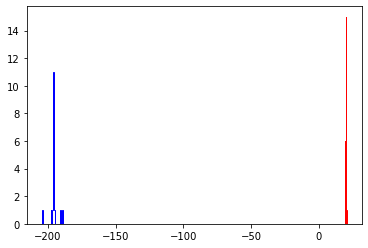

In [64]:
# perform the LDA on the reduced data space
cov_tot_pca = np.cov(np.vstack([x1_pca, x2_pca]).T, bias=True)
dim_pca = x1_pca.shape[1]

n_x1 = len(x1)
n_x2 = len(x2)
cov_wc = (n_x1*np.cov(x1_pca.T, bias=True) + n_x2*np.cov(x2_pca.T, bias=True)) / (n_x1 + n_x2)
cov_ac = cov_tot_pca - cov_wc
d_lda, e_lda = scipy.linalg.eigh(cov_ac, cov_wc, eigvals=(dim_pca-1, dim_pca-1))

# now we've got our one dimensional data
x1_lda = x1_pca.dot(e_lda)
x2_lda = x2_pca.dot(e_lda)

# ... and plot the lda result.. beautiful...
plt.figure()
junk = plt.hist(x1_lda, 40, histtype='step', color='b')
junk = plt.hist(x2_lda, 40, histtype='step', color='r')
plt.show()

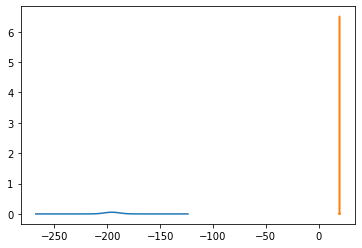

======Target test data evaluation======
True -1820 -23493 21673 ../data/target_dev/m429_03_p03_i0_0.png
False -2345 -8227 5882 ../data/target_dev/m429_03_p01_i0_0.png
True -1383 -45281 43897 ../data/target_dev/m429_03_p04_i0_0.png
True -1278 -52212 50934 ../data/target_dev/m429_03_r06_i0_0.png
True -2113 -13776 11662 ../data/target_dev/m429_03_r08_i0_0.png
True -1676 -29598 27922 ../data/target_dev/m429_03_p05_i0_0.png
False -2404 -7077 4672 ../data/target_dev/m429_03_r10_i0_0.png
True -1545 -36022 34477 ../data/target_dev/m429_03_r07_i0_0.png
False -2796 -1785 -1011 ../data/target_dev/m429_03_p02_i0_0.png
True -1707 -28203 26495 ../data/target_dev/m429_03_r09_i0_0.png

======Non-target test data evaluation======
False -5247 -28958 23711 ../data/non_target_dev/m424_04_f19_i0_0.png
True -3997 -4913 916 ../data/non_target_dev/f407_02_f19_i0_0.png
True -2898 -1019 -1878 ../data/non_target_dev/f408_01_r09_i0_0.png
True -3632 -1442 -2189 ../data/non_target_dev/f407_04_f19_i0_0.png
True -228

In [68]:
# compute the gaussian distributions for our classes and evalueate the test data
apriori = 0.5
mean_x1, cov_x1 = train_gauss(x1_lda)
mean_x2, cov_x2 = train_gauss(x2_lda)

# plot the gaussians... awesome..
plt.figure()
gauss_x1 = np.linspace(mean_x1 - 10*cov_x1, mean_x1 + 10*cov_x1, 100)
gauss_x2 = np.linspace(mean_x2 - 10*cov_x2, mean_x2 + 10*cov_x2, 100)
plt.plot(gauss_x1, stats.norm.pdf(gauss_x1, mean_x1, cov_x1))
plt.plot(gauss_x2, stats.norm.pdf(gauss_x2, mean_x2, cov_x2))
plt.show()

print('======Target test data evaluation======')
for filename, data in test_target:
    # standardise the data
    data = data.flatten()
    data -= np.mean(data)
    data /= np.std(data)
    
    data = (data.dot(e_pca)).dot(e_lda) # transform the test data
    ll_target = logpdf_gauss(data, mean_x1, np.atleast_2d(cov_x1))
    ll_ntarget = logpdf_gauss(data, mean_x2, np.atleast_2d(cov_x2))

    # indicates whether the data point was correctly classified
    if int(sum(ll_target) - sum(ll_ntarget)) > THRESHOLD: correct = True
    else: correct = False
    
    print(correct, int(sum(ll_target)), int(sum(ll_ntarget)), int(sum(ll_target) - sum(ll_ntarget)), filename)


print('')
print('======Non-target test data evaluation======')
for filename, data in test_ntarget:
    # standardise the data
    data = data.flatten()
    data -= np.mean(data)
    data /= np.std(data)
    
    data = (data.dot(e_pca)).dot(e_lda)
    ll_target = logpdf_gauss(data, mean_x1, np.atleast_2d(cov_x1))
    ll_ntarget = logpdf_gauss(data, mean_x2, np.atleast_2d(cov_x2))
    
    # indicates whether the data point was correctly classified
    if int(sum(ll_target) - sum(ll_ntarget)) < THRESHOLD: correct = True
    else: correct = False
          
    print(correct, int(sum(ll_target)), int(sum(ll_ntarget)), int(sum(ll_target) - sum(ll_ntarget)), filename)
